In [ ]:
!uv pip install matplotlib pandas


In [1]:
import torch
import triton 
import triton.language as tl

DEVICE = torch.device(f"cuda:{torch.cuda.current_device()}")
print(f"Using device: {DEVICE}")

Using device: cuda:0


In [2]:
autotune_configs = [
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE': 8}, num_stages=3, num_warps=8),
    triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE': 8}, num_stages=5, num_warps=2),
    triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE': 8}, num_stages=5, num_warps=2),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE': 8}, num_stages=3, num_warps=8),
    triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE': 8}, num_stages=4, num_warps=4),
]

@triton.autotune(configs=autotune_configs, key=['M','N','K'])
@triton.jit
def _matmul_kernel(
    a_ptr, b_ptr, c_ptr,
    M, N, K,
    stride_a_M, stride_a_K,
    stride_b_K, stride_b_N,
    stride_c_M, stride_c_N,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE: tl.constexpr,  # how many block line in a group
):
    PID = tl.program_id(axis=0)
    block_num_M = tl.cdiv(M, BLOCK_SIZE_M)
    block_num_N = tl.cdiv(N, BLOCK_SIZE_N)
    block_num_in_group = GROUP_SIZE * block_num_N

    group_id = PID // block_num_in_group
    first_block_id_in_group_M = group_id * GROUP_SIZE

    group_size = min(block_num_M - first_block_id_in_group_M, GROUP_SIZE)
    
    block_id_M = first_block_id_in_group_M + ((PID % block_num_in_group) % group_size)
    block_id_N = (PID % block_num_in_group) // group_size

    offsets_M = block_id_M * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offsets_N = block_id_N * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offsets_K = tl.arange(0, BLOCK_SIZE_K)

    a_ptrs = a_ptr + (offsets_M[:, None] * stride_a_M + offsets_K[None, :] * stride_a_K)
    b_ptrs = b_ptr + (offsets_K[:, None] * stride_b_K + offsets_N[None, :] * stride_b_N)
    
    mask_m = offsets_M < M
    mask_n = offsets_N < N
 

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        mask_k = offsets_K < K - k

        a = tl.load(a_ptrs, mask=mask_m[:, None] & mask_k[None, :], other=0.0)
        b = tl.load(b_ptrs, mask=mask_k[:, None] & mask_n[None, :], other=0.0)

        accumulator = tl.dot(a, b, acc=accumulator)
        a_ptrs += BLOCK_SIZE_K * stride_a_K
        b_ptrs += BLOCK_SIZE_K * stride_b_K
    
    c_offsets = stride_c_M * offsets_M[:, None] + stride_c_N * offsets_N[None, :]
    c_mask = mask_m[:, None] & mask_n[None, :]
    tl.store(c_ptr + c_offsets, accumulator.to(tl.float16), mask=c_mask)

In [3]:
def matmul(a: torch.Tensor, b: torch.Tensor):
    assert a.ndim == b.ndim == 2
    assert a.shape[1] == b.shape[0]

    (M, K), (_, N) = a.shape, b.shape

    c = torch.empty((M, N), device=DEVICE, dtype=torch.float16)
    '''
    [0, 1]
    [2, 3]
    '''
    grid = lambda meta: (
        triton.cdiv(M, meta['BLOCK_SIZE_M']) * triton.cdiv(N, meta['BLOCK_SIZE_N']),
    )
    _matmul_kernel[grid](
        a, b, c,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
    )
    return c



In [4]:
def test_matmul_kernel(size1, size2: tuple, atol=1e-2, rtol=1e-1, device=DEVICE):
    torch.manual_seed(0)
    assert type(size1) == tuple and len(size1) == 2
    assert type(size2) == tuple and len(size2) == 2
    assert size1[1] == size2[0]

    a = torch.randn(size1, device=DEVICE, dtype=torch.float16)
    b = torch.randn(size2, device=DEVICE, dtype=torch.float16)

    c_tri = matmul(a, b)
    c_ref = torch.matmul(a, b)

    torch.testing.assert_close(c_tri, c_ref, atol=atol, rtol=rtol)
    print('PASSED')


In [5]:
test_matmul_kernel(size1=(1024, 512),size2=(512, 256))

PASSED


In [6]:
configs = [
    triton.testing.Benchmark(
        x_names = ["M", "N", "K"], # we can increase multiple dimensions simultaneously while benchmarking
        x_vals = [128 * i for i in range(2, 33)],
        line_arg = "provider", 
        line_vals = ["torch", "triton"],
        line_names = ["PyTorch", "Triton"],
        styles = [("green", "-"), ("blue", "-")],
        ylabel = "TFLOPS", 
        plot_name = "matmul-performance",
        args={},
    )
]
@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    b = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    quantiles = [0.5, 0.05, 0.95]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 3 * M * N * K * 1e-12 / (ms * 1e-3)
        # 3 = number of memory operations (2 read + 1 write)
        # M * N * K = number of elements per memory op
        # 1e-12 converts flops to Teraflops
        # 1e-3 converts milliseconds to seconds
    return perf(ms), perf(max_ms), perf(min_ms)

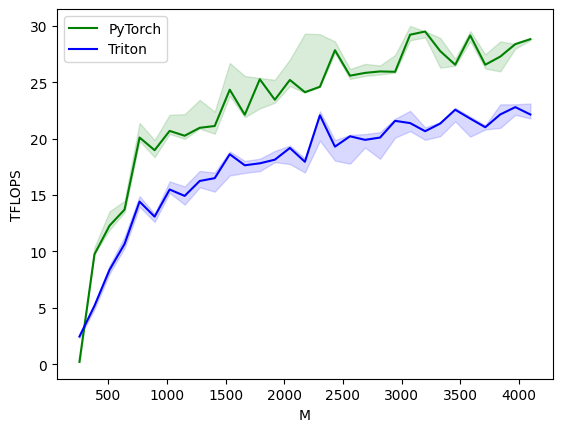

In [12]:
benchmark.run(print_data=False)